## Variational Auto Encoders using Jax

Application to Fashion MNIST dataset, available from tensorflow datasets.
Prerequisites:
- [tensorflow datasets](https://www.tensorflow.org/datasets) (we won't use tensorflow)
- [Jax](https://github.com/google/jax) 

No GPU required, but the notebook will make use of it if you have one.
The dataset considered is Fashion MNIST, which is lightweight and easy to use, and still more interesting than MNIST.

In [66]:
from tensorflow.keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

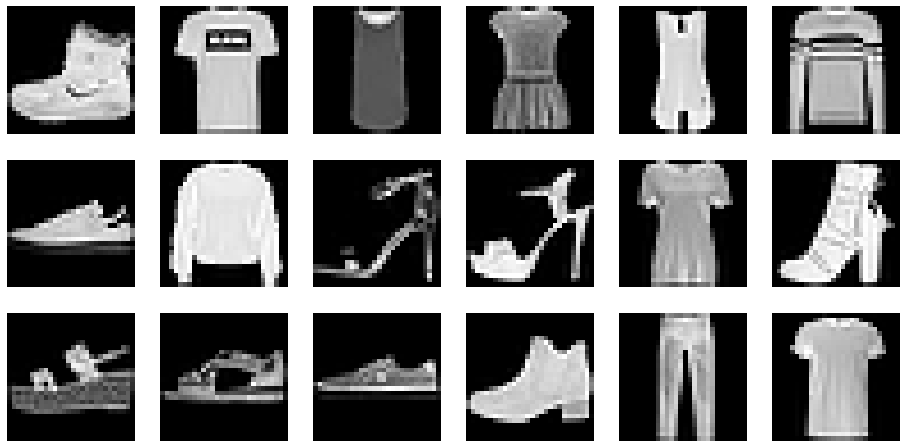

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

plt.figure(figsize=(16, 8))
for i in range(0, 18):
    plt.subplot(3, 6, i + 1)
    plt.imshow(x_train[i], cmap="gray")
    plt.axis("off")
plt.show()

In [ ]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [ ]:
x_train_standard = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_standard = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
x_train_standard.shape, x_test_standard.shape

### Jax mini tutorial

[Jax](https://github.com/google/jax) enables to use python and numpy functions with automatic gradient computation, and fast linear algebra through just in time (jit) compilation (see [XLA](https://www.tensorflow.org/xla))

In [ ]:
import jax
import jax.numpy as jnp
from jax import jit, grad

You may use jnp as you would use numpy normally, doing so will enable the autograd and the optimizations

In [ ]:
W = jnp.zeros((2,3))
x = jnp.zeros((2))
jnp.dot(x, W)

#### Random numbers with jax

In [ ]:
from jax import random
rand_key = random.PRNGKey(1)

In Jax the random state when generating pseudo random numbers is not automatically updated. This is [on purpose](https://github.com/google/jax/blob/master/design_notes/prng.md).
For example, run the following example several times using ctrl-enter, noticing that the same random numbers are:

In [ ]:
random.normal(rand_key, shape=(2,3))

To manually update the state (`rand_key` here), the usual practice is to use the `random.split` function, to get two new random keys. You may then update the state using one of them, and use the other for generation of random numbers.

In [ ]:
k1, k2 = random.split(rand_key)

#you can update the rand_key
rand_key = k1

#use k2
random.normal(k2, shape=(2,3))

### Building the Encoder

The inference model is defined as: 

$$\mu_z(\mathbf{x}), \sigma_z(\mathbf{x}) = encoder_{\phi}(\mathbf{x})$$
$$q_\phi(z|x) = \mathcal{N}(z; \mathbf{\mu}_z, diag(\mathbf{\sigma}_z)) $$

We first build $encoder_{\phi}$ as a MLP with a single hidden layer. Note that $\mu_z$ and $\sigma_z$ are $k$-dimensionnal where $k$ is the dimension of the latent space. For visualization purposes we'll choose $k = 2$.

The following cells define the parameters $\phi$ (named here `params_enc`) as several weigth matrices and biases, that we initialize through standard initialization schemes, then the encoder function itself.

Note that in practice the output of the encoder network parameterizes $log(\sigma^2_z(x))$ instead of $\sigma_z(x)$. Taking the exponential of $log(\sigma^2_z(x))$ ensures the positivity of the standard deviation from the raw output of the network.

In [ ]:
from jax.experimental import stax # neural network library
from jax.experimental.stax import Dense, Relu, Sigmoid

input_dim = x_train_standard.shape[-1]
hidden_dim = 128
latent_dim = 2

encoder_init, encoder_fn = stax.serial(
    Dense(hidden_dim), Relu, Dense(latent_dim * 2))

#initialize the parameters
rand_key, key = random.split(rand_key)
out_shape, params_enc = encoder_init(rand_key, (-1, input_dim))

The use of `jit` enables just in time compilation which will strongly improve computation speed. The first time you run it, it will compile (and thus be slower), subsequent runs will be faster. You may check this by running the following cell several times with ctrl-enter:

In [ ]:
%time z = jit(encoder_fn)(params_enc, x_train_standard[0:10])
%time z = encoder_fn(params_enc, x_train_standard[0:10])
print(z)

### Reparametrization trick

We use the reparametrization trick to define a random variable z that is conditioned on the input image x as follows:

$$ z \sim \mathcal{N}(z, \mu_z(x), diag(\sigma_z(x))) $$

The reparametrization tricks defines $z$ has follows:

$$ z = \mu_z(x) + \sigma_z(x) \cdot \epsilon$$

with:

$$ \epsilon \sim \mathcal{N}(0, 1) $$

This way the dependency to between $z$ and $x$ is deterministic and differentiable. The randomness of $z$ only stems from $\epsilon$ only for a given $x$.

In [ ]:
def sample(rand_key, z_mean, z_log_var):
    epsilon = random.normal(rand_key, shape=z_mean.shape)
    return z_mean + jnp.exp(z_log_var / 2) * epsilon

fast_sample = jit(sample)

### Building the Decoder

We will build the following architecture:

$$x^\prime = decoder_{\theta}(\mathbf{z})$$

where the decoder is a MLP with a single hidden layer. 

We first define the parameters $\theta$ (named here `params_dec`) as several weigth matrices and biases, that we initialize through standard initialization schemes.

In [ ]:
decoder_init, decoder_fn = stax.serial(
    Dense(hidden_dim), Relu, Dense(input_dim), Sigmoid)

#initialize the parameters
rand_key, key = random.split(rand_key)
out_shape, params_dec = decoder_init(rand_key, (-1, latent_dim))

params = params_enc + params_dec

In [ ]:
[len(param) for param in params]
# corresponds to:
# Encoder dense [W,b], encoder Relu, encoder dense [W,b], 
# decoder dense [W,b], decoder Relu, decoder dense [W,b], decoder sigmoid

### VAE

Let's now the plug the encoder and decoder via the stochastic latent variable $z$ to get the full VAE architecture. The loss function is the negative ELBO of the variational inference problem, the sum of: 

- crossentropy loss between the input and its reconstruction through the autoencoder
- KL divergence between the distributions of $z$ and the prior distribution (centered gaussian)

note that we will consider all parameters $\phi \cup \theta$ as an argument of the loss function, so that Jax is able to differentiate with regards to each of the parameters: `params = params_enc + params_dec`

In [ ]:
EPSILON = 1e-6
xent = jit(lambda x, xt: - jnp.sum(x * jnp.log(xt + EPSILON) + (1-x)*jnp.log(1-xt+EPSILON), axis=-1))
kl = jit(lambda z_mean, z_log_var: - 0.5 * jnp.sum(1 + z_log_var - z_mean ** 2 - jnp.exp(z_log_var), axis=-1))

@jit
def vae_loss(rand_key, params, x):
    latent = jit(encoder_fn)(params[0:3], x)
    d = latent.shape[-1]//2
    z_mean, z_log_var = latent[:, :d], latent[:,d:]
    z_sample = jit(sample)(rand_key, z_mean, z_log_var)
    x_rec = jit(decoder_fn)(params[3:], z_sample)
    xent_loss = xent(x, x_rec)
    kl_loss = kl(z_mean, z_log_var)
    # average over the batch, and sum kl / xent
    loss = jnp.mean(xent_loss) + jnp.mean(kl_loss) 
    return loss

In [ ]:
%time vae_loss(rand_key, params, x_train_standard[0:10])

### Training the VAE

The following cells:
    - reinitialize parameters
    - initialize an Adam optimizer
    - run a batch training over 5 epochs

In [ ]:
# You may run this cell to reinit parameters if needed
_, params_enc = encoder_init(rand_key, (-1, input_dim))
_, params_dec = decoder_init(rand_key, (-1, latent_dim))
params = params_enc + params_dec

In [ ]:
from jax.experimental import stax, optimizers

data_size = x_train_standard.shape[0]
batch_size = 32
learning_rate = 0.001

opt_init, opt_update, get_params = optimizers.adam(learning_rate)
opt_state = opt_init(params)

losses = []

In [ ]:
@jit
def update(key, batch, opt_state):
    params = get_params(opt_state)
    value_and_grad_fun = jit(jax.value_and_grad(lambda params, x: vae_loss(key, params, x)))
    loss, grads = value_and_grad_fun(params, batch)
    opt_state = opt_update(0, grads, opt_state)
    return opt_state, loss

In [ ]:
for epochs in range(5):
    for i in range(data_size // 32 - 1):
        batch = x_train_standard[i * 32:(i+1)*32]
        rand_key, key = random.split(rand_key)
        opt_state, loss = update(key, batch, opt_state)
        losses.append(loss)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses);

### Image generation

We can test the decoder with random samples from the prior distribution of $z$. You may run the following cell several times through ctrl-enter

In [ ]:
rand_key, key = random.split(key)
params = get_params(opt_state)
params_dec = params[3:]
z = random.normal(key, shape=(1,latent_dim))
generated = decoder_fn(params_dec, z)
plt.imshow(generated.reshape(28, 28), cmap=plt.cm.gray)
plt.axis('off');

### 2D plot of the image classes in the latent space

We can also use the encoder to set the visualize the distribution of the test set in the 2D latent space of the VAE model. In the following the colors show the true class labels from the test samples.

Note that the VAE is an unsupervised model: it did not use any label information during training. However we can observe that the 2D latent space is largely structured around the categories of images used in the training set.

In [ ]:
id_to_labels = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 
                5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

In [ ]:
x_test_encoded = encoder_fn(params[0:3], x_test_standard)
plt.figure(figsize=(7, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test,
            cmap=plt.cm.tab10)
cb = plt.colorbar()
cb.set_ticks(list(id_to_labels.keys()))
cb.set_ticklabels(list(id_to_labels.values()))
cb.update_ticks()
plt.show()

### 2D panel view of samples from the VAE manifold

The following linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian to produce values of the latent variables z. This makes it possible to use a square arangement of panels that spans the gaussian prior of the latent space.

In [ ]:
n = 15  # figure with 15x15 panels
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n)).astype(np.float32)
grid_y = norm.ppf(np.linspace(0.05, 0.95, n)).astype(np.float32)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder_fn(params[3:], z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()